# a gentle exploration tour through the Monad-Bayes library

https://github.com/adscib/monad-bayes

In [1]:
:e OverloadedStrings

import qualified Graphics.Vega.VegaLite as VL
import Graphics.Vega.VegaLite hiding (filter)
import IHaskell.Display.Hvega (vlShow)
import Data.Aeson (ToJSON(toJSON), Value)
import Data.Aeson (encode)
import qualified Data.ByteString.Lazy.Char8 as BL

import Control.Monad (liftM2, replicateM)
import Control.Monad.IO.Class (liftIO)
import Control.Monad.Bayes.Class
import Control.Monad.Bayes.Sampler
import Control.Monad.Bayes.Inference.RMSMC as RMSMC
import Control.Monad.Bayes.Sequential
import Control.Monad.Bayes.Population
import Control.Monad.Bayes.Traced.Static (Traced)
import Control.Monad.Bayes.Inference.SMC
import Data.Vector (fromList, toList)
import Statistics.Sample.KernelDensity (kde)


import Numeric.Log
import Control.Monad.Bayes.Class


barPlot :: [Double] -> VegaLite
barPlot dataSamples = 
  let desc = description "Probability Games"
      dat = dataFromColumns []
          . dataColumn "Result" (Numbers dataSamples)
      trans = transform
        . binAs [ MaxBins 20 ] "Result" "binnedData"
      conf = configure
        . configuration (Axis [ DomainWidth 1 ])
        . configuration (BarStyle [ MContinuousBandSize 20 ])
        . configuration (SelectionStyle [ ( Single, [ On "dblclick" ] ) ])
      barOpts = [MOpacity 1.0, MColor "blue"]
      enc = encoding
            . position X [PName "Result", PmType Quantitative, PAxis [AxGrid True, AxTitle "Toss Value"]]
            . position Y [PName "binnedData", PmType Quantitative, PAxis [AxGrid False]]
  in toVegaLite [desc, width 600, height 200, dat [], trans [], conf [], mark Bar barOpts, enc []]
  
linePlot :: [Double] -> [Double] -> VegaLite
linePlot xSamples ySamples = 
  let desc = description "Logistic Regression"
      dat = dataFromColumns []
          . dataColumn "X" (Numbers xSamples)
          . dataColumn "Y" (Numbers ySamples)
      conf = configure
        . configuration (Axis [ DomainWidth 1 ])
        . configuration (SelectionStyle [ ( Single, [ On "dblclick" ] ) ])
      enc = encoding
            . position X [PName "X", PmType Quantitative, PAxis [AxGrid True, AxTitle "Toss Value"]]
            . position Y [PName "Y", PmType Quantitative, PAxis [AxGrid False]]
  in toVegaLite [desc, width 600, height 200, dat [], conf [], mark Line [], enc []]

pointPlot :: [Double] -> [Double] -> VegaLite
pointPlot xSamples ySamples = 
  let desc = description "Logistic Regression"
      dat = dataFromColumns []
          . dataColumn "X" (Numbers xSamples)
          . dataColumn "Y" (Numbers ySamples)
      conf = configure
        . configuration (Axis [ DomainWidth 1 ])
        . configuration (SelectionStyle [ ( Single, [ On "dblclick" ] ) ])
      enc = encoding
            . position X [PName "X", PmType Quantitative, PAxis [AxGrid True, AxTitle "Toss Value"]]
            . position Y [PName "Y", PmType Quantitative, PAxis [AxGrid False]]
  in toVegaLite [desc, width 600, height 200, dat [], conf [], mark Point [MOpacity 0.2], enc []]
  
density2DPlot :: [Double] -> [Double] -> VegaLite
density2DPlot xSamples ySamples = 
  let desc = description "Logistic Regression"
      dat = dataFromColumns []
          . dataColumn "X" (Numbers xSamples)
          . dataColumn "Y" (Numbers ySamples)
      conf = configure
        . configuration (Axis [ DomainWidth 1 ])
        . configuration (SelectionStyle [ ( Single, [ On "dblclick" ] ) ])
        . configuration (View [ViewStroke (Just "transparent")])
      enc = encoding
            . position X [PName "X", PBin [MaxBins 20], PmType Quantitative, PAxis [AxGrid True, AxTitle "Toss Value"]]
            . position Y [PName "Y", PBin [MaxBins 20], PmType Quantitative, PAxis [AxGrid False]]
            . color [ MAggregate Count, MName "col", MmType Quantitative, MScale [SScheme "blues"[0.0, 1.0]]]
  in toVegaLite [desc, width 300, height 300, dat [], conf [], mark Rect [], enc []]

## A Gaussian Toy Model

In [2]:
gaussian :: MonadInfer m => [Double] -> m (Double, Double)
gaussian os = do
  c <- uniform (-0.5) 0.5
  s <- uniform 0.5 1.0
  mapM_ (score . normalPdf c s) os
  return (c, s)
  
generateDataGaussian :: MonadSample m
      => Int  -- ^ Number of points
      -> m [Double] -- ^ List of latent and observable states from t=1
generateDataGaussian n = replicateM n $ normal 0 0.1

In [3]:
runModel :: IO [((Double, Double), Log Double)]
runModel = sampleIOfixed $ do
  ys <- generateDataGaussian 50
  res <- runPopulation $ (RMSMC.rmsmc 100 10 10) (gaussian ys)
  return res
  
runModel

Line 2: Redundant return
Found:
do ys <- generateDataGaussian 50
   res <- runPopulation $ (RMSMC.rmsmc 100 10 10) (gaussian ys)
   return res
Why not:
do ys <- generateDataGaussian 50
   runPopulation $ (RMSMC.rmsmc 100 10 10) (gaussian ys)Line 4: Redundant bracket
Found:
(RMSMC.rmsmc 100 10 10) (gaussian ys)
Why not:
RMSMC.rmsmc 100 10 10 (gaussian ys)

[((-8.933493531459702e-2,0.5068287953900739),3.432840311164619e-11),((-7.208342190316908e-2,0.5118051359349169),3.432840311164619e-11),((-0.21347520671537035,0.5392372331968052),3.432840311164619e-11),((8.207728631069389e-2,0.5006324063422118),3.432840311164619e-11),((-0.1437519737421854,0.5229573268830032),3.432840311164619e-11),((0.20708731047806317,0.5565640901233249),3.432840311164619e-11),((-0.13914773844926598,0.5046444504795156),3.432840311164619e-11),((-7.567361211862855e-3,0.51879727410227),3.432840311164619e-11),((-0.16231767522516372,0.5305638573537379),3.432840311164619e-11),((-4.698914798945242e-3,0.5312181276476171),3.432840311164619e-11)]

## Modelling Dice

In [4]:
-- A toy model for dice rolling from http://dl.acm.org/citation.cfm?id=2804317
-- Exact results can be obtained using Dist monad

-- | A toss of a six-sided die.
die :: MonadSample m => m Int
die = uniformD [1..6]

-- | A sum of outcomes of n independent tosses of six-sided dice.
dice :: MonadSample m => Int -> m Int
dice 1 = die
dice n = liftM2 (+) die (dice (n-1))

In [5]:
-- | Toss of two dice where the output is greater than 4.
dice_hard :: MonadInfer m => m Int
dice_hard = do
  result <- dice 2
  condition (result > 8)
  return result

Line 2: Use camelCase
Found:
dice_hard :: MonadInfer m => m Int
Why not:
diceHard :: MonadInfer m => m IntLine 3: Use camelCase
Found:
dice_hard = ...
Why not:
diceHard = ...

In [6]:
takeFromModel :: Int -> Sequential (Population SamplerIO) a -> IO [a]
takeFromModel nsamples inModel = sampleIOfixed $ do
    res <- runPopulation $ smcMultinomial 1 nsamples inModel
    return $ map fst res

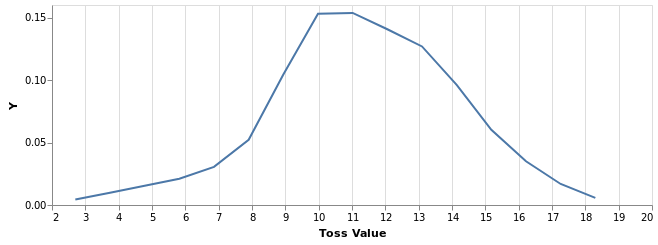

In [7]:
samples <- takeFromModel 100 (dice 3)
(bins, counts) = kde 10 (fromList (fromIntegral <$> samples))
vlShow $ linePlot (toList bins) (toList counts)

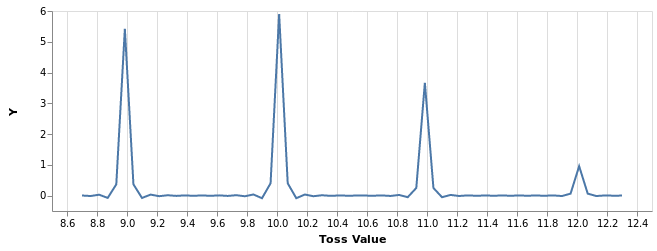

In [8]:
samples <- takeFromModel 100 dice_hard
(bins, counts) = kde 50 (fromList (fromIntegral <$> samples))
vlShow $ linePlot (toList bins) (toList counts)

## Two alternating distributions

In [9]:
prior :: MonadSample m => m Double
prior = return 0.2

modelFalse :: MonadSample m => m Int
modelFalse = uniformD ([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12] :: [Int])

modelTrue :: MonadSample m => m Int
modelTrue = do
  x <- bernoulli 0.5
  y <- uniformD (if x then [1, 2] else [11, 12] :: [Int])
  return y

Line 8: Redundant return
Found:
do x <- bernoulli 0.5
   y <- uniformD (if x then [1, 2] else [11, 12] :: [Int])
   return y
Why not:
do x <- bernoulli 0.5
   uniformD (if x then [1, 2] else [11, 12] :: [Int])

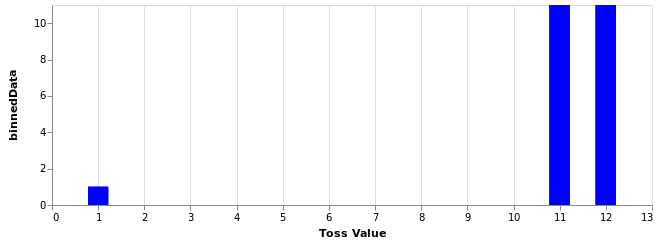

In [10]:
samples <- takeFromModel 20 modelTrue
vlShow $ barPlot $ fromIntegral <$> samples

## Logistic Regression

In [11]:
xs = [-10, -5, 2, 6, 10]
xsDouble = fromInteger <$> xs
labels = [False, False, True, True, True]
ysDouble = fromIntegral <$> fromEnum <$> labels

Line 4: Functor law
Found:
fromIntegral <$> fromEnum <$> labels
Why not:
fromIntegral . fromEnum <$> labels

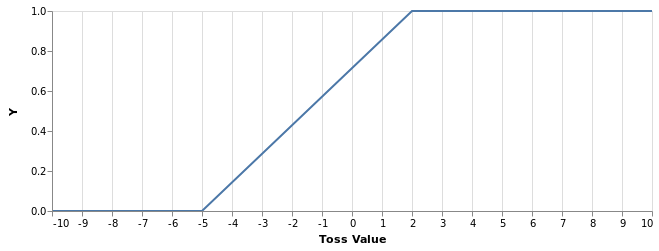

In [12]:
vlShow $ linePlot xsDouble ysDouble

both normal and gamma are functions that take two parameters and that return distributions with the _MonadSample_ interface:

In [13]:
:t normal
:t gamma

normal :: forall (m :: * -> *). MonadSample m => Double -> Double -> m Double

gamma :: forall (m :: * -> *). MonadSample m => Double -> Double -> m Double

we now build a sigmoid function from those. First we build a scaled and shifted normal distribution that is then passed through the exponential.

In [14]:
sigmoid :: MonadSample m => Double -> m Double
sigmoid x = do
    m <- normal 0 1
    b <- normal 0 1
    sigma <- gamma 1 1
    n <- normal (m * x + b) sigma
    return (1 / (1 + exp (- n)))

we can take 100 samples of the final distribution at a few x values and plot the resulting model distribution ...

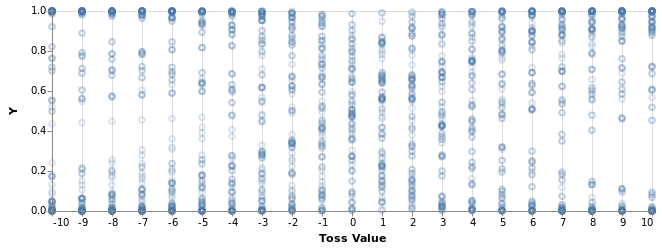

In [15]:
nsamples = 100
xValues = [-10..10]
yValues <- sequence (takeFromModel nsamples <$> (sigmoid <$> xValues))
xPoints = xValues >>= replicate nsamples
yPoints = mconcat yValues
vlShow $ pointPlot xPoints yPoints

here is the distribution as a density plot

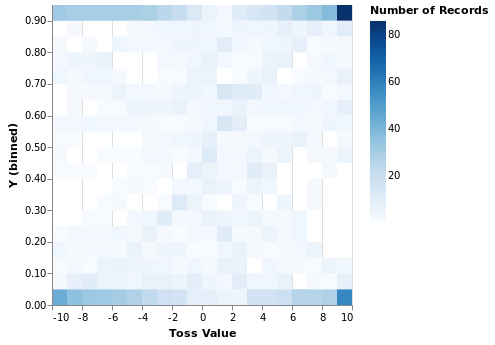

In [16]:
vlShow $ density2DPlot xPoints yPoints

the sigmoidal structure of the distribution becomes quite clear. The goal of the inference algorithm will be to find parameters that correspond to the observed values. We start with the definition of a helper function `obs` that returns an empty instance of the MonadInfer class. This class can sample and score different execution paths.

In [17]:
obs :: (MonadInfer m) => Double -> Bool -> m ()
obs x label = do
      p <- sigmoid x -- get the y Value (True=1, False=0) of the sigmoid at point x
      score $ (Exp . log) $ if label then p else 1 - p

In [18]:
logisticRegression :: (MonadInfer m) => [(Double, Bool)] -> m Double
logisticRegression dat = do
  mapM_ (uncurry obs) dat
  sigmoid 10

model = logisticRegression (zip xs labels)

In [19]:
samples <- takeFromModel 100 model
(bins, counts) = kde 10 (fromList samples)

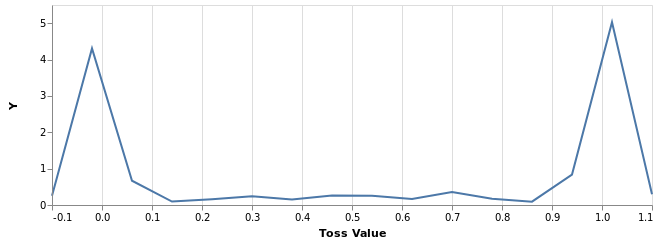

In [20]:
vlShow $ linePlot (toList bins) (toList counts)

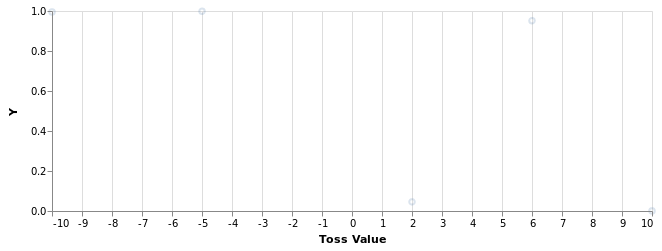

In [21]:
xValues = xs
yValues <- takeFromModel nsamples model
vlShow $ pointPlot xValues yValues